In [1]:
import os 
from pathlib import Path

path = Path('data')
os.listdir(path)

['example_test.csv',
 'train.csv',
 'asset_details.csv',
 'supplemental_train.csv',
 'example_sample_submission.csv']

In [46]:
import pandas as pd 

try:
    train_clean = pd.read_csv(path / 'train_clean.csv')
except:
    train = pd.read_csv(path / 'train.csv')
    train = train.sort_values(by=['timestamp', 'Asset_ID'])
    train.index = pd.to_datetime(train['timestamp'] * 1e9)
    train_clean = train.groupby('Asset_ID').ffill().bfill()
    train_clean['Asset_ID'] = train['Asset_ID'].values.copy()
    train_clean = train_clean.groupby('Asset_ID').resample('1Min').ffill().bfill()
    train_clean.reset_index(level=0, drop=True, inplace=True)
    train_clean = train_clean.sort_index()
    train_clean.to_csv(path / 'train_clean.csv')

train_clean

,timestamp,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_ID
timestamp,,,,,,,,,,
2018-01-01 00:01:00,1514764860,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,-0.014399,0
2018-01-01 00:01:00,1514764860,40.0,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,-0.004218,2
2018-01-01 00:01:00,1514764860,32.0,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,-0.013922,5
2018-01-01 00:01:00,1514764860,173.0,738.302500,746.000000,732.510000,738.507500,3.359879e+02,738.839291,-0.004809,6
2018-01-01 00:01:00,1514764860,5.0,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,-0.008264,7
...,...,...,...,...,...,...,...,...,...,...
2021-09-21 00:00:00,1632182400,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,0.000449,12
2021-09-21 00:00:00,1632182400,403.0,542.093333,542.620000,539.630000,541.045000,5.828307e+02,541.684504,-0.000482,2
2021-09-21 00:00:00,1632182400,2698.0,43009.961250,43048.510000,42961.640000,43002.505000,1.282068e+02,43011.414052,0.002726,1


In [227]:
train_btc = train_clean[train_clean['Asset_ID'] == 1][-10000:-100]
test_btc = train_clean[train_clean['Asset_ID'] == 1][-100:]

len(train_btc), len(test_btc)

(9900, 100)

In [228]:
import numpy as np

def generate_windows(data, size):
    windows = []
    for i in range(len(data) - size + 1):
        windows.append(data[i:i+size])
    return np.stack(windows) 

window_size = 10
train_windows = generate_windows(train_btc['Target'].values.astype(np.float32), window_size + 1)
test_windows = generate_windows(test_btc['Target'].values.astype(np.float32), window_size + 1)

x_train, y_train = train_windows[:, :-1], train_windows[:, -1:]
x_test, y_test = test_windows[:, :-1], test_windows[:, -1:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((9890, 10), (90, 10), (9890, 1), (90, 1))

In [238]:
import matplotlib.pyplot as plt

def plot_windows(x, y, y_pred=None, rows=3, cols=3):
    fig = plt.figure(dpi=200)
    for i in range(rows*cols):
        ax = plt.subplot(rows, cols, i+1)
        ax.plot(range(0, len(x[i])), x[i], '-x')
        ax.plot(range(len(x[i]), len(x[i])+1), y[i], '-rx')
        if y_pred is not None:
            ax.plot(range(len(x[i]), len(x[i])+1), y_pred[i], '-b.')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.plot()

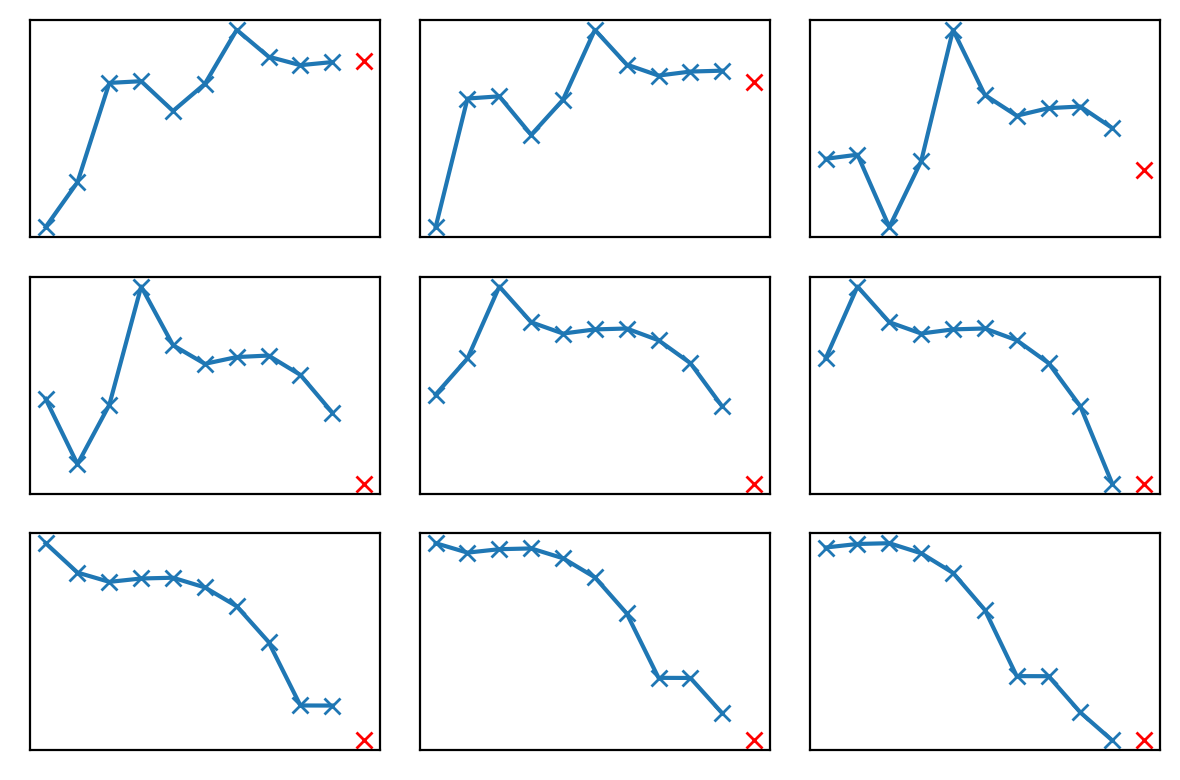

In [230]:
plot_windows(x_train, y_train)

In [231]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(x_train, y_train),
    'test': TimeSeriesDataset(x_test, y_test)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [232]:
x, y = next(iter(dataloader['train']))

x.shape, y.shape, x.dtype

(torch.Size([64, 10]), torch.Size([64, 1]), torch.float32)

In [233]:
import torch 

hidden_dim = 100
mlp = torch.nn.Sequential(
    torch.nn.Linear(window_size, hidden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim, 1)
)

mlp

Sequential(
  (0): Linear(in_features=10, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [234]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['test']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f" Epoch {epoch}/{epochs} loss {np.mean(train_loss):.8f} val_loss {np.mean(eval_loss):.8f}")

In [235]:
fit(mlp, dataloader, epochs=100)

 Epoch 100/100 loss 0.00000025 val_loss 0.00000083: 100%|██████████| 100/100 [00:09<00:00, 10.37it/s]


In [236]:
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X, _ = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [249]:
y_pred = predict(mlp, dataloader['test'])

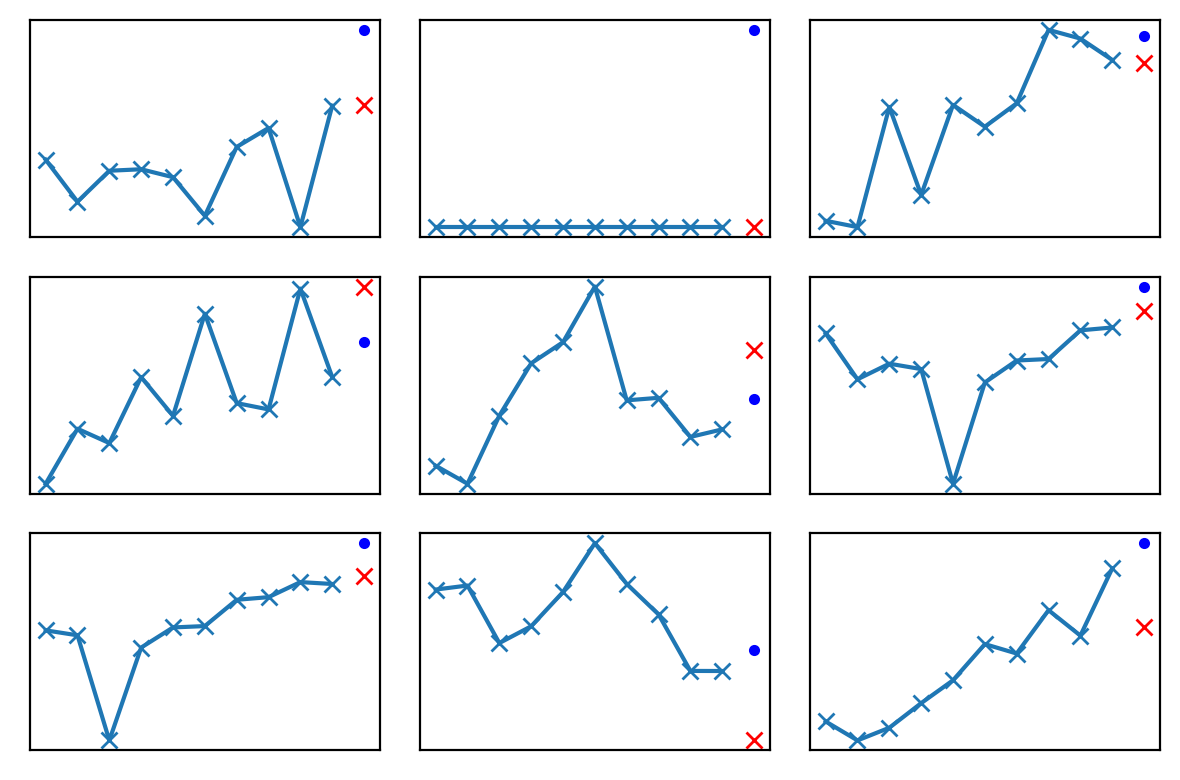

In [267]:
ixs = np.arange(len(y_pred))
np.random.shuffle(ixs)

plot_windows(x_test[ixs,...], y_test[ixs,...], y_pred[ixs,...])